## 4PopSplit  

In [1]:
import stdpopsim
import numpy as np
from matplotlib import pyplot as plt
import statistics
import math
import tskit
from collections import Counter
import csv
from sklearn.linear_model import LinearRegression
import msprime
from random import sample 
%load_ext rpy2.ipython

In [2]:
def split(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate):

    # Times are provided in years, so we convert into generations.
    generation_time = 25
    T_S1 = split_time1 / generation_time
    T_S2 = split_time2 / generation_time


    # Population IDs correspond to their indexes in the population
    # configuration array. Therefore, we have 0=A, 1=B, 2=C, 3=D initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=sample_A, initial_size=N_A),
        msprime.PopulationConfiguration(
            sample_size=sample_B, initial_size=N_B), 
        msprime.PopulationConfiguration(
            sample_size=sample_C, initial_size=N_C),
        msprime.PopulationConfiguration(
            sample_size=sample_D, initial_size=N_D)
    ]

    demographic_events = [
        msprime.MassMigration(
            time=T_S2, source=3, destination=2, proportion=1.0),
        msprime.MassMigration(
            time=T_S2, source=1, destination=0, proportion=1.0),
        msprime.MassMigration(
            time=T_S1, source=2, destination = 0, proportion=1.0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    #dd.print_history()
    
    ts = msprime.simulate(population_configurations=population_configurations,
                         demographic_events=demographic_events, length=seg_length, recombination_rate=recomb_rate)
    ts = msprime.mutate(ts,rate=mut_rate)
    return ts

In [3]:
def genotype_matrix(ts, sample_A, sample_B, sample_C, sample_D):
    G = ts.genotype_matrix()
    A = G[:,0:sample_A]
    B = G[:,sample_A:(sample_A+sample_B)]
    C = G[:,(sample_A+sample_B):(sample_A+sample_B+sample_C)]
    D = G[:,(sample_A+sample_B+sample_C):(sample_A+sample_B+sample_C+sample_D)]
    return A, B, C, D

In [4]:
def make_diploids(G_hap, ploidy):
    G = np.empty((G_hap.shape[0], (G_hap.shape[1]//ploidy)))
    num_hap = list(range(0,int(G_hap.shape[1]),1))
    indxs = random_choice_noreplace2(list(range(0,int(G_hap.shape[1]),1)), ploidy,(G_hap.shape[1]//ploidy))
    
    for i in range(0, (G_hap.shape[1]//ploidy)):
        G[:,i] = add_haploids(indxs[i], G_hap)
        
    return G

In [5]:
def add_haploids(indx,G_hap):
    tmp = np.sum(G_hap[:,indx],1)
    return tmp

In [6]:
def random_choice_noreplace2(l, n_sample, num_draw):
    '''
    l: 1-D array or list
    n_sample: sample size for each draw
    num_draw: number of draws

    Intuition: Randomly generate numbers, get the index of the smallest n_sample number for each row.
    '''
    l = np.array(l)
    return l[np.argpartition(np.random.rand(num_draw,len(l)), n_sample-1,axis=-1)[:,:n_sample]]

In [7]:
def make_panel(pop1, pop2):
    return np.concatenate((pop1,pop2), axis=0)

In [8]:
def get_effect_sizes(L, h2, m):
    B = np.zeros(L)
    for i in range(0,L):
        if i % m == 0:
            B[i] = np.random.normal(0,h2/m)
    return B

In [9]:
def get_X(G, B):  
    X = []
    for i in range(0,G.shape[0]):
        X.append(np.dot(B,G[i,]))
    return X

In [10]:
def get_Z(X, n):
    Z = []
    mu_x = statistics.mean(X)
    std_x = statistics.stdev(X)
    for i in range(0,n):
        Z.append((X[i]-mu_x) / std_x)
    return Z

In [11]:
def get_Ze(n, h2): 
    e = []
    for i in range(0,n):
        e.append(np.random.normal(0,1-h2))
    Ze = []
    mu_e = statistics.mean(e)
    std_e = statistics.stdev(e)
    for i in range(0,n):
        Ze.append((e[i]-mu_e) / std_e)
        
    return Ze

In [12]:
def get_L(Z, Ze, h2, n):
    L = []
    for i in range(0,n):
        G_comp = math.sqrt(h2) * Z[i]
        E_comp = math.sqrt(1-h2) * Ze[i]
        #Stratification effect in African 
        #if i > (G.shape[1]/2): 
        #    E_comp = E_comp + abs(np.random.normal(2,1))
        L.append(G_comp+E_comp)
    return L

In [48]:
def get_phenotypes(B, G, h2, m):
    n = G.shape[0]
    X = get_X(G, B)
    n= G.shape[0]
    Z = get_Z(X, n)
    Ze = get_Ze(n, h2)
    L = get_L(Z, Ze, h2, n)
    return L

In [14]:
def GWAS(G_sample, phenotype):
    marg_beta = np.zeros(G_sample.shape[1])
    y = np.array(phenotype)
    for i in range(0,G_sample.shape[1]):
        x = G_sample[:,i].reshape(-1, 1)
        #model = LogisticRegression(solver='liblinear', random_state=0).fit(x, y)
        model = LinearRegression().fit(x, y)
        marg_beta[i] = model.coef_
    return marg_beta

In [15]:
def PGS(G, beta_hat):
    X = []
    for i in range(0,G.shape[0]):
        X.append(np.dot(beta_hat,G[i,]))
    return X   

In [16]:
def make_test_vec(n):
    t = np.zeros(n)
    t[0:int(n/2)] = 1
    return np.reshape(t, (-1, 1))

In [17]:
def mean_center(mat):
    meanPoint = mat.mean(axis = 0)
    return (mat - meanPoint)

def divide_by_sd(mat):
    smat = mat ** 2
    sums = smat.sum(axis = 0)
    return (mat / np.sqrt(sums))

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [18]:
def get_eigenvectors(cov_mat):
    eig = np.linalg.eig(cov_mat)
    return eig

In [19]:
def get_test_vec_coeffs(tvec, vecs):
    betas = np.transpose(vecs) @ tvec 
    return betas[0:-1,]

In [20]:
def non_seg_index(mat, ploidy):
    lost = np.where(mat.sum(axis=0) == 0)
    fixed = np.where(mat.sum(axis=0) == (np.shape(mat)[0]*ploidy))
    return(np.concatenate((lost,fixed), axis=None))

In [116]:
def get_sigma_s(M, Tm):
    H = np.zeros((M.shape[1], M.shape[1]))
    np.fill_diagonal(H,np.var(M, axis=0))
    sigma_s = np.transpose(Tm) @ M @ H / (np.shape(M)[0] - 1) 
    return sigma_s

In [117]:
def get_strat_term(sigma_s, X, sTvec):
    return (sigma_s @ np.transpose(X) @ sTvec) / (np.shape(X)[0] - 1)  

In [222]:
## Parameters
N_A=2000
N_B=2000 
N_C=2000
N_D=2000
split_time1=140e3 
split_time2=70e3 
sample_A=100
sample_B=100
sample_C=100
sample_D=100
seg_length=1e6 
recomb_rate=5e-7 
mut_rate=5e-8

ploidy=2

Santiy Checks: 

[-0.10086861 -0.10367023 -0.10018958 -0.10138604 -0.10368186 -0.10009418
 -0.10140946 -0.0983738  -0.09973164 -0.09830649 -0.09911256 -0.10016725
 -0.10042738 -0.10075448 -0.10257902 -0.09692037 -0.09973293  0.10292435
  0.10138858  0.0995589   0.10139448  0.09854491  0.09788216  0.09617316
  0.09995255  0.10154069  0.1014753   0.10019915  0.09752971  0.09820172
  0.10020206  0.09939719  0.0988905   0.10113664  0.09794167  0.10143222
  0.1008382   0.10083949  0.09939022  0.09663959  0.09824411  0.09967257
  0.10153486  0.09662534  0.0999024   0.10241851  0.1017403   0.1010504
  0.10120691  0.10180741  0.09806897  0.09866987  0.10000685  0.09896798
  0.09929598  0.09860573  0.101931    0.10029788  0.09944047  0.10246684
  0.10036266  0.0998069   0.09697917  0.10121408  0.1025597   0.1015616
  0.10128367 -0.10043171 -0.10031216 -0.10341152 -0.10028835 -0.09809387
 -0.10029641 -0.09896802 -0.10234373 -0.10039145 -0.09783423 -0.10066071
 -0.09971181 -0.10429095 -0.09950313 -0.09725211 -0.0

array([-0.10086861, -0.10367023, -0.10018958, -0.10138604, -0.10368186,
       -0.10009418, -0.10140946, -0.0983738 , -0.09973164, -0.09830649,
       -0.09911256, -0.10016725, -0.10042738, -0.10075448, -0.10257902,
       -0.09692037, -0.09973293,  0.10292435,  0.10138858,  0.0995589 ,
        0.10139448,  0.09854491,  0.09788216,  0.09617316,  0.09995255,
        0.10154069,  0.1014753 ,  0.10019915,  0.09752971,  0.09820172,
        0.10020206,  0.09939719,  0.0988905 ,  0.10113664,  0.09794167,
        0.10143222,  0.1008382 ,  0.10083949,  0.09939022,  0.09663959,
        0.09824411,  0.09967257,  0.10153486,  0.09662534,  0.0999024 ,
        0.10241851,  0.1017403 ,  0.1010504 ,  0.10120691,  0.10180741,
        0.09806897,  0.09866987,  0.10000685,  0.09896798,  0.09929598,
        0.09860573,  0.101931  ,  0.10029788,  0.09944047,  0.10246684,
        0.10036266,  0.0998069 ,  0.09697917,  0.10121408,  0.1025597 ,
        0.1015616 ,  0.10128367, -0.10043171, -0.10031216, -0.10

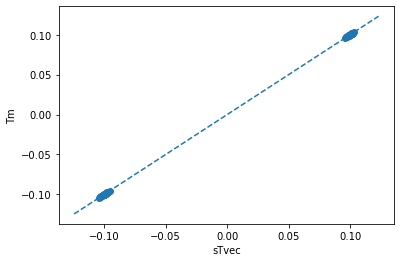

In [236]:
ts = split(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate)
geno_mat = genotype_matrix(ts, sample_A,sample_B,sample_C,sample_D)

A = np.transpose(make_diploids(geno_mat[0], ploidy))
B = np.transpose(make_diploids(geno_mat[1], ploidy))
C = np.transpose(make_diploids(geno_mat[2], ploidy))
D = np.transpose(make_diploids(geno_mat[3], ploidy))

# Make Test/Gwas Panel
X = make_panel(A,C)
M = make_panel(B,D)

# Remove non-segregating sites
trm = np.concatenate((non_seg_index(X, ploidy), non_seg_index(M, ploidy)), axis=None)
X = np.delete(X,trm, axis=1)
M = np.delete(M,trm, axis=1)

# Remove Duplicates
new_array = [tuple(row) for row in X]
X = np.unique(new_array, axis=0)
new_array = [tuple(row) for row in M]
M = np.unique(new_array, axis=0)

# Make Test Vector
Tvec = make_test_vec(X.shape[0])
Tvec = np.random.rand(50)

# Mean Center
X = mean_center(X)
M = mean_center(M)
Tvec = mean_center(Tvec)


# Get Covariance matric 
test_cov = X @ np.transpose(X) /(np.shape(X)[1] - 1)

# Standarize T
sTvec = divide_by_sd(Tvec)

# Eigen Decomposition
vals, vecs = get_eigenvectors(test_cov)

# Eigenvalue Tvec 
Tvec = mean_center(vecs[:,0])
sTvec = divide_by_sd(Tvec)


# Get Test Vector Coefficients
betas = get_test_vec_coeffs(sTvec, vecs)

# Calculate Tm
out = np.empty((betas.shape[0], test_cov.shape[1]))
for i in range(0,betas.shape[0]):
    out[i,:] = betas[i] * ((test_cov @ vecs[:,i]) / vals[i])
Tm = out.sum(axis=0)

# Calculate Tm a different way 
Tm = test_cov @ vecs[:,0:-1] @ np.diag(np.ones((np.shape(vals)[0]-1))/vals[0:-1]) @ np.transpose(vecs[:,0:-1]) @ sTvec

plt.scatter(sTvec, Tm)
abline(1, 0)
plt.xlabel("sTvec")
plt.ylabel("Tm")

print(Tm)
sTvec

In [207]:
%%R -i X,sTvec,test_cov,M,A,B,C,D

library(Matrix)

set.seed(12)

## get test covariance matrix and eigendecomposition
test.cov <- X %*% t(X) / (ncol(X)-1)
eig <- eigen(test.cov)
vecs <- eig$vectors
vals <- eig$values
neigs <- length(vals)

random_cont_test_vec <- function(n){
  # Make the test vector random, drawn from a uniform distribution 
  tvec <- runif(n)
  ctvec <- (tvec-mean(tvec))
  std.tvec <- ctvec/sqrt(sum(ctvec^2))
  return(std.tvec)  
}
std.tvec <- random_cont_test_vec(50)
std.tvec <- sTvec

# get betas
betas <- t(vecs) %*% std.tvec
betas <- betas[1:ncol(vecs)-1]

# Calculate Tm
out <- matrix(NA, ncol = 50, nrow = 49)
for (i in 1:49){
   out[i, ] = betas[i] * ((test.cov %*% vecs[,i]) / vals[i])
 }
Tm = colSums(out)

# Calculate Tm a different way 
Tm = test.cov %*% vecs[,1:49] %*% diag(1/vals[1:49]) %*% t(vecs[,1:49]) %*% std.tvec
#plot(std.tvec,Tm)
#abline(a=0,b=1,col='red',lty=2)

print(rankMatrix(X))
vals


[1] 45
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 1.796341e-13
 [1]  2.142069e+01  8.218179e-01  7.102892e-01  5.469880e-01  4.680931e-01
 [6]  4.213847e-01  3.285226e-01  2.879624e-01  2.684216e-01  2.595736e-01
[11]  2.244269e-01  2.037583e-01  1.857775e-01  1.709674e-01  1.674583e-01
[16]  1.607964e-01  1.287272e-01  1.240688e-01  1.233104e-01  1.191553e-01
[21]  1.162183e-01  9.544498e-02  9.243558e-02  9.187012e-02  8.222247e-02
[26]  7.282562e-02  7.011356e-02  5.906380e-02  5.418522e-02  5.184901e-02
[31]  5.018306e-02  4.166543e-02  3.604903e-02  3.147471e-02  2.852902e-02
[36]  2.444482e-02  2.175258e-02  2.036046e-02  1.882435e-02  1.697287e-02
[41]  1.190133e-02  1.043426e-02  8.447706e-03  2.378426e-03  1.972410e-03
[46]  6.753301e-16  9.918843e-17 -1.777097e-16 -2.260109e-16 -4.888400e-16


array([ 2.14206931e+01+0.0000000e+00j,  8.21817880e-01+0.0000000e+00j,
        7.10289184e-01+0.0000000e+00j,  5.46988014e-01+0.0000000e+00j,
        4.68093145e-01+0.0000000e+00j,  4.21384715e-01+0.0000000e+00j,
        3.28522645e-01+0.0000000e+00j,  2.87962373e-01+0.0000000e+00j,
        2.68421608e-01+0.0000000e+00j,  2.59573555e-01+0.0000000e+00j,
        2.24426888e-01+0.0000000e+00j,  2.03758277e-01+0.0000000e+00j,
        1.85777503e-01+0.0000000e+00j,  1.70967432e-01+0.0000000e+00j,
        1.67458347e-01+0.0000000e+00j,  1.60796404e-01+0.0000000e+00j,
        1.28727168e-01+0.0000000e+00j,  1.24068795e-01+0.0000000e+00j,
        1.23310446e-01+0.0000000e+00j,  1.19155323e-01+0.0000000e+00j,
        1.16218257e-01+0.0000000e+00j,  9.54449778e-02+0.0000000e+00j,
        9.24355837e-02+0.0000000e+00j,  9.18701208e-02+0.0000000e+00j,
        8.22224720e-02+0.0000000e+00j,  7.28256192e-02+0.0000000e+00j,
        7.01135577e-02+0.0000000e+00j,  5.90638002e-02+0.0000000e+00j,
      

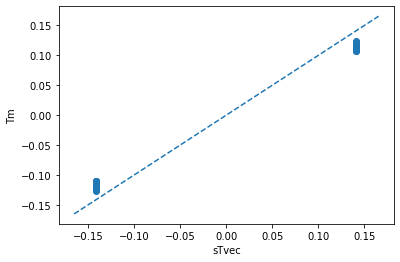

In [205]:
# The test Panel is B/D and GWAS Panel is A/C
ts = split(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate)
geno_mat = genotype_matrix(ts, sample_A,sample_B,sample_C,sample_D)

A = np.transpose(make_diploids(geno_mat[0], ploidy))
B = np.transpose(make_diploids(geno_mat[1], ploidy))
C = np.transpose(make_diploids(geno_mat[2], ploidy))
D = np.transpose(make_diploids(geno_mat[3], ploidy))

# Make Test/Gwas Panel
X = make_panel(A,C)
M = make_panel(B,D)

# Remove non-segregating sites
trm = np.concatenate((non_seg_index(X, ploidy), non_seg_index(M, ploidy)), axis=None)
X = np.delete(X,trm, axis=1)
M = np.delete(M,trm, axis=1)

# Make Test Vector
Tvec = make_test_vec(X.shape[0])
#Tvec = np.random.rand(50)

# Mean Center
X = mean_center(X)
M = mean_center(M)
Tvec = mean_center(Tvec)

# Get Covariance matric 
test_cov = X @ np.transpose(X) /(np.shape(X)[1] - 1)

# Standarize T
sTvec = divide_by_sd(Tvec)

# Eigen Decomposition
vals, vecs = get_eigenvectors(test_cov)

# Calculate Tm
K = M @ np.transpose(X) /(np.shape(X)[1] - 1) # check denominator 
Tm = K @ vecs[:,0:-1] @ np.diag(np.ones((np.shape(vals)[0]-1))/vals[0:-1]) @ np.transpose(vecs[:,0:-1]) @ sTvec

plt.scatter(sTvec, Tm)
abline(1, 0)
plt.xlabel("sTvec")
plt.ylabel("Tm")

sigma_s = get_sigma_s(M, Tm)
strat = get_strat_term(sigma_s, X, sTvec)


array([[-0.00388014-1.00806359e-16j],
       [ 0.0264266 +1.47519032e-17j],
       [-0.04702083-2.25692821e-18j],
       [-0.00521748+1.00432252e-17j],
       [-0.0463083 -4.66380710e-17j],
       [-0.00484453-6.75280375e-17j],
       [-0.02425774+4.73515494e-18j],
       [-0.00532515+3.25512799e-18j],
       [-0.00481678+7.29620502e-18j],
       [ 0.05610349+8.77474780e-18j],
       [ 0.02553187+1.49198951e-18j],
       [-0.00637788-2.70616191e-17j],
       [ 0.05415145-1.75625134e-17j],
       [ 0.0264266 +1.47519032e-17j],
       [-0.00632434-8.68673131e-17j],
       [ 0.00386079+1.43221795e-17j],
       [-0.00441417+1.89410655e-17j],
       [-0.00599627+1.25871791e-16j],
       [-0.00481678+7.29620502e-18j],
       [-0.00328343-9.52418815e-18j],
       [-0.00441417+1.18704755e-17j],
       [ 0.02262331+4.52794153e-18j],
       [-0.02980788+1.39293837e-17j],
       [-0.05104849-5.65056710e-17j],
       [-0.00443517+7.70936836e-18j],
       [-0.00369484+8.15397434e-18j],
       [-0.0

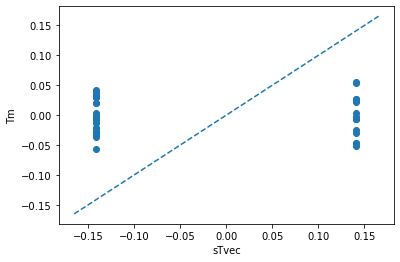

In [166]:
# The test Panel is B/D and GWAS Panel is A/C
ts = split(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate)
geno_mat = genotype_matrix(ts, sample_A,sample_B,sample_C,sample_D)

A = np.transpose(make_diploids(geno_mat[0], ploidy))
B = np.transpose(make_diploids(geno_mat[1], ploidy))
C = np.transpose(make_diploids(geno_mat[2], ploidy))
D = np.transpose(make_diploids(geno_mat[3], ploidy))

# Make Test/Gwas Panel
X = make_panel(C,D)
M = make_panel(A,B)

# Remove non-segregating sites
trm = np.concatenate((non_seg_index(X, ploidy), non_seg_index(M, ploidy)), axis=None)
X = np.delete(X,trm, axis=1)
M = np.delete(M,trm, axis=1)

# Make Test Vector
Tvec = make_test_vec(X.shape[0])
#Tvec = np.random.rand(50)

# Mean Center
X = mean_center(X)
M = mean_center(M)
Tvec = mean_center(Tvec)

# Get Covariance matric 
test_cov = X @ np.transpose(X) /(np.shape(X)[1] - 1)

# Standarize T
sTvec = divide_by_sd(Tvec)

# Eigen Decomposition
vals, vecs = get_eigenvectors(test_cov)

# Calculate Tm
K = M @ np.transpose(X) /(np.shape(X)[1] - 1)
Tm = K @ vecs[:,0:-1] @ np.diag(np.ones((np.shape(vals)[0]-1))/vals[0:-1]) @ np.transpose(vecs[:,0:-1]) @ sTvec

plt.scatter(sTvec, Tm)
abline(1, 0)
plt.xlabel("sTvec")
plt.ylabel("Tm")

sigma_s = get_sigma_s(M, Tm)
strat = get_strat_term(sigma_s, X, sTvec)
strat

Tm

In [155]:
def main(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate, ploidy, config): 
    
    # The test Panel is B/D and GWAS Panel is A/C
    ts = split(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate)
    geno_mat = genotype_matrix(ts, sample_A,sample_B,sample_C,sample_D)

    A = np.transpose(make_diploids(geno_mat[0], ploidy))
    B = np.transpose(make_diploids(geno_mat[1], ploidy))
    C = np.transpose(make_diploids(geno_mat[2], ploidy))
    D = np.transpose(make_diploids(geno_mat[3], ploidy))

    # Make Test/Gwas Panel
    if config == True:
        X = make_panel(C,D)
        M = make_panel(A,B)
    elif config == False:  
        X = make_panel(B,D)
        M = make_panel(A,C)
        
    # Remove non-segregating sites
    trm = np.concatenate((non_seg_index(X, ploidy), non_seg_index(M, ploidy)), axis=None)
    X = np.delete(X,trm, axis=1)
    M = np.delete(M,trm, axis=1)

    # Make Test Vector
    Tvec = make_test_vec(X.shape[0])

    # Mean Center
    X = mean_center(X)
    M = mean_center(M)
    Tvec = mean_center(Tvec)

    # Get Covariance matric 
    test_cov = X @ np.transpose(X) /(np.shape(X)[1] - 1)

    # Standarize T
    sTvec = divide_by_sd(Tvec)

    # Eigen Decomposition
    vals, vecs = get_eigenvectors(test_cov)

    # Calculate Tm
    K = M @ np.transpose(X) /(np.shape(X)[1] - 1)
    Tm = K @ vecs[:,0:-1] @ np.diag(np.ones((np.shape(vals)[0]-1))/vals[0:-1]) @ np.transpose(vecs[:,0:-1]) @ sTvec

    sigma_s = get_sigma_s(M, Tm)
    strat = get_strat_term(sigma_s, X, sTvec)
    return strat[0][0]

[51.926721957133765, 42.11671998697976, (47.38423267806567-5.424719312221953e-13j), 36.292156012703394, (33.626290902487355-6.2371309800538e-16j), (51.8609319184704-1.3259117574513904e-13j), 55.78639796020625, 35.78629081187798, 36.62870950432294, 39.597651302836105, 25.108635301389437, 23.330563851502564, (40.73330654944786+1.0870798902711359e-14j), 21.362699331909017, 26.269820089213212, (44.77419620538007+1.1124291250550928e-13j), 23.65629482645597, 20.7679674257765, 43.161958879547996, 27.59416853516209, (46.726297002784904-1.0143357625933318e-14j), 54.0275954527, (30.234543716114736+2.5760084661496415e-13j), 30.927564959102973, 31.094097918387753]


(array([4., 3., 3., 1., 3., 2., 3., 2., 2., 2.]),
 array([20.76796743+0.j, 24.26981048+0.j, 27.77165353+0.j, 31.27349659+0.j,
        34.77533964+0.j, 38.27718269+0.j, 41.77902575+0.j, 45.2808688 +0.j,
        48.78271185+0.j, 52.28455491+0.j, 55.78639796+0.j]),
 <a list of 10 Patch objects>)

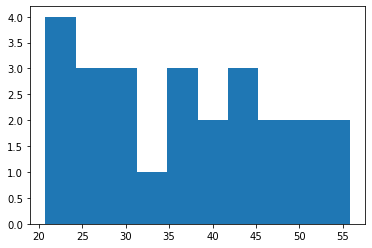

In [158]:
out = []
for i in range(0, 25):
    out.append(main(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate, ploidy, False))
print(out)
plt.hist(out)

[0.1932050815285173, (0.4928681840385287+3.27240647220686e-16j), 0.04467654481617398, (0.4658990817898396+5.473323402744058e-18j), (0.16922585935349507+1.4492479835042593e-18j), 1.52504030658812, (0.21818875387037664+1.5250147377511836e-15j), (0.6620345052801004+4.1866796368330504e-17j), 0.10660877201343759, 0.0394356620190621, 0.5122237397721153, (0.4480516010599798+6.765365666663243e-14j), (0.5387753237172282-1.3395661426373748e-16j), -0.023818041382960824, 1.9649816158570685, 0.4991153834825803, -0.32462215672463085, 0.011670070684460642, 0.0563100808506059, -0.10456747251124274, (0.04803753046435157-1.9781689705941062e-17j), 0.01690995374486577, 0.04020382484607452, 0.24817914204673092, 0.18493664167410273]


(array([2., 9., 5., 6., 1., 0., 0., 0., 1., 1.]),
 array([-0.32462216+0.j, -0.09566178+0.j,  0.1332986 +0.j,  0.36225898+0.j,
         0.59121935+0.j,  0.82017973+0.j,  1.04914011+0.j,  1.27810048+0.j,
         1.50706086+0.j,  1.73602124+0.j,  1.96498162+0.j]),
 <a list of 10 Patch objects>)

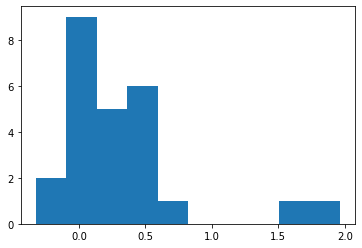

In [160]:
out = []
for i in range(0, 25):
    out.append(main(N_A, N_B, N_C, N_D, split_time1, split_time2, sample_A, sample_B, sample_C, sample_D, seg_length, recomb_rate, mut_rate, ploidy, True))
    
print(out)
plt.hist(out)

Run GWAS

(array([ 4.,  3.,  6., 17.,  7.,  5.,  4.,  1.,  2.,  1.]),
 array([-90.94754353, -68.58760908, -46.22767464, -23.8677402 ,
         -1.50780575,  20.85212869,  43.21206314,  65.57199758,
         87.93193202, 110.29186647, 132.65180091]),
 <a list of 10 Patch objects>)

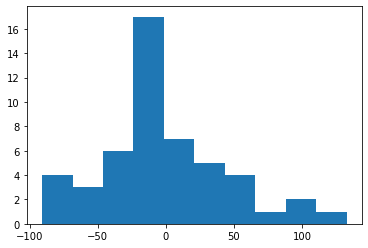

In [68]:
m = 100
h2 = 0.8
L = M.shape[1]
true_effect = get_effect_sizes(L, h2,m)

phenotypes_gwas = get_phenotypes(true_effect, M, h2, num_loci)
beta_hat = GWAS(M, phenotypes_gwas)
pgs_test = PGS(M, beta_hat)

plt.hist(pgs_test)

In [72]:
np.savetxt("../data/4PopSplit/testCD_X.txt", X)
np.savetxt("../data/4PopSplit/testCD_M.txt", M)
np.savetxt("../data/4PopSplit/testCD_T.txt", sTvec)

In [75]:
np.savetxt("../data/4PopSplit/testBD_X.txt", X)
np.savetxt("../data/4PopSplit/testBD_M.txt", M)
np.savetxt("../data/4PopSplit/testBD_T.txt", sTvec)